# Gradient Boosting

O algoritmo Gradient Boosting é uma técnica de aprendizado de máquina para problemas de regressão e classificação que produz um modelo de previsão a partir de uma combinação de modelos de previsão fracos, geralmente árvores de decisão.

O objetivo do algoritmo é criar uma corrente de modelos fracos, onde cada um tem como objetivo minimizar o erro do modelo anterior, por meio de uma função de perda.

Aos ajustes de cada modelo fraco é multiplicado um valor chamado de taxa de aprendizagem. Esse valor, tem como objetivo determinar o impacto de cada árvore no modelo final. Quanto menor o valor, menor a contribuição de cada árvore.

Nesta primeira parte, será construído o modelo de Gradient Boosting utilizando uma técnica de divisão de dados fixa na proporção de 70/30.

In [238]:
# Bibliotecas
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

In [239]:
# Utilizando os dados codificados
df = pd.read_csv('datasets/updated_pollution_dataset_encoded.csv')

In [240]:
# Separando o atributo alvo dos preditores
X = df.drop('Air Quality Encoded', axis=1)
y = df['Air Quality Encoded']

In [241]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [260]:
# Definindo o modelo e seus hiperparâmetros
clf = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=0.1, 
                                max_depth=3, 
                                random_state=42)

In [243]:
# Treinando o modelo com dados de treino
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [244]:
y_pred_gb = clf.predict(X_test)
# print(y_pred_gb)

In [245]:
acuracia_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='macro')
precisao_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
print(f"Métricas \nAcurácia: {acuracia_gb} \nF1-score: {f1_gb} \nPrecisão: {precisao_gb} \nRecall: {recall_gb}")

Métricas 
Acurácia: 0.9566666666666667 
F1-score: 0.9410905376680458 
Precisão: 0.9418757686123935 
Recall: 0.9403323362031227


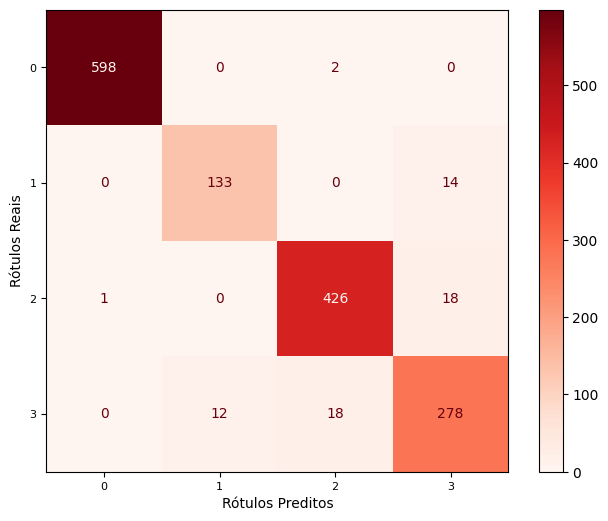

In [246]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax = ax, cmap='Reds')

ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

Sabendo que o objetivo deste modelo é aprimorar os resultados a cada passo, podemos analisar também a evolução da média de erros ao longo dos estágios da Gradient Boosting

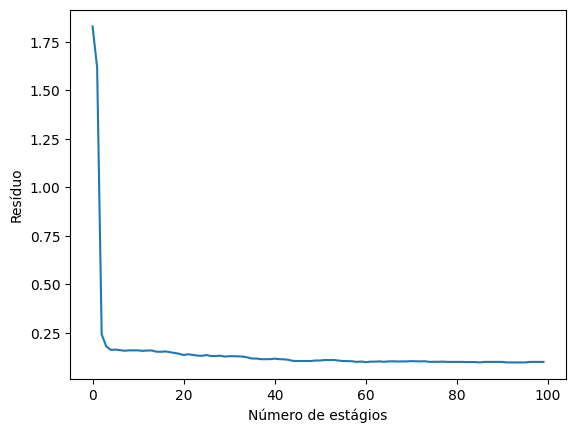

In [ ]:
residuos = [mean_squared_error(y_test, y_pred) for y_pred in clf.staged_predict(X_test)]

plt.plot(residuos)
plt.ylabel('Resíduo')
plt.xlabel('Número de estágios')
plt.show()

## Gradient Boosting com validação cruzada

A validação cruzada consiste em dividir o conjunto de dados em K partes (ou folds) e, a cada iteração, usa-se K-1 folds para o treino do modelo e o K restante, para o teste. Essa técnica permite que todos os dados sejam usados tanto para treino quanto para validação, buscando garantir uma validação mais robusta e menos enviesada.

In [248]:
# Definindo o número de folds utilizado
num_folds = 5

In [249]:
metricas_desejadas = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [250]:
modelo_kfold = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [ ]:
# A função cross_validate realiza o treino e o teste do modelo
resultados_validacaocruzada = cross_validate(modelo_kfold, X, y, scoring=metricas_desejadas, cv=num_folds)

acuracia_kfold = resultados_validacaocruzada['test_accuracy'].mean()
precisao_kfold= resultados_validacaocruzada['test_precision_macro'].mean()
f1_kfold = resultados_validacaocruzada['test_f1_macro'].mean()
recall_kfold = resultados_validacaocruzada['test_recall_macro'].mean()

print("Métricas\n")
print(f"Acurácia: {acuracia_kfold:.2f} \nPrecisão: {precisao_kfold:.2f} \nRecall: {recall_kfold:.2f} \nF1-score: {f1_kfold:.2f}")

Métricas

Acurácia: 0.95 
Precisão: 0.94 
Recall: 0.93 
F1-score: 0.93


C:\Users\proje\AppData\Local\Temp\ipykernel_17096\1712237100.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


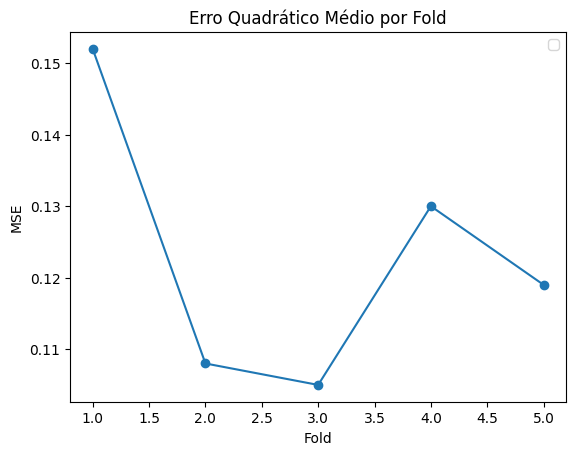

In [253]:
erro_quadrado_kfold = cross_validate(modelo_kfold, X, y, cv=5, scoring='neg_mean_squared_error')

mse_folds = -erro_quadrado_kfold['test_score']


plt.plot(range(1, 6), mse_folds, marker='o')
plt.title('Erro Quadrático Médio por Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

## Gradient Boosting com GridSearch

A técnica de GridSearchCV realiza uma busca sobre um conjunto de parâmetros predefinidos afim de evitar a arbitrariedade em um único modelo. Utilizá-la ao implementar um algoritmo de Gradient Boosting permite que tenhamos uma maior variedade de modelos para análise de sua eficiência de acordo com seus hiperparâmetros. Assim, nesta parte, faremos a implementação do GridSearch junto ao Gradient Boosting para explorarmos novos modelos e compararmos com os obtidos anteriormente.

In [ ]:
grid_gb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.05, 0.2]
 }

grid_search_gb = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 42),
                           param_grid = grid_gb,
                           cv = 5,
                           n_jobs = -1,
                           scoring = 'f1_macro',
                           verbose= 2)

grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='f1_macro', verbose=2)

In [255]:
print("Melhores parâmetros encontrados:", grid_search_gb.best_params_)
print(f"Melhor F1-score médio: {grid_search_gb.best_score_}")

Melhores parâmetros encontrados: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
Melhor F1-score médio: 0.9218694098453859


In [ ]:
y_pred_gs = grid_search_gb.best_estimator_.predict(X_test)

acuracia_gs = accuracy_score(y_test, y_pred_gs)
precisao_gs = precision_score(y_test, y_pred_gs, average = 'macro') 
recall_gs = recall_score(y_test, y_pred_gs, average = 'macro')
f1_gs = f1_score(y_test, y_pred_gs, average = 'macro')

print("Métricas\n")
print(f"Acurácia: {acuracia_gs:.2f} \nPrecisão: {precisao_gs:.2f} \nRecall: {recall_gs:.2f} \nF1-Score: {f1_gs:.2f}")

Métricas

Acurácia: 0.9846666666666667 
Precisão: 0.9780778709569418 
Recall: 0.9794271910672637 
F1-Score: 0.9786923170001958


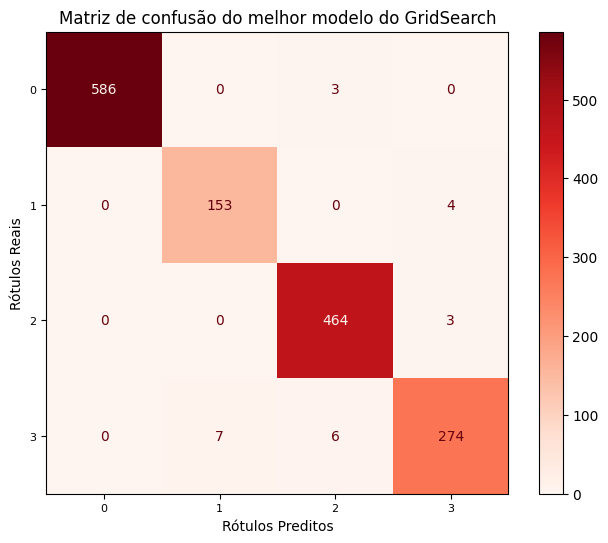

In [266]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gs, ax = ax, cmap='Reds')

plt.title('Matriz de confusão do melhor modelo do GridSearch')
ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

C:\Users\proje\AppData\Local\Temp\ipykernel_17096\2748990280.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


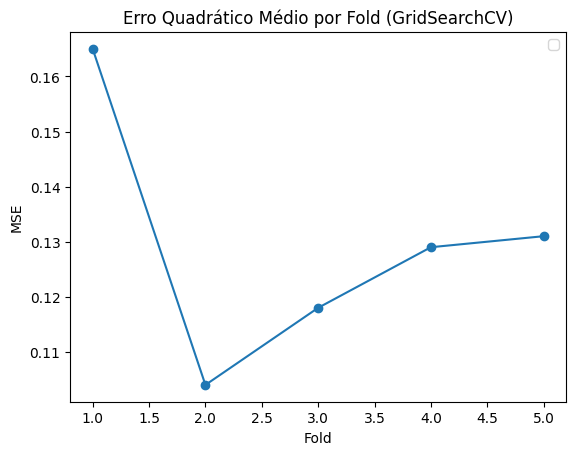

In [257]:
resultados_modelo_final = cross_validate(grid_search_gb.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')


mse_folds = -resultados_modelo_final['test_score']


plt.plot(range(1, 6), mse_folds, marker='o')
plt.title('Erro Quadrático Médio por Fold (GridSearchCV)')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

In [258]:
os.makedirs('gradient_boosting', exist_ok = True)
joblib.dump(clf, 'gradient_boosting/gradientboosting_air_quality_standard.joblib')
joblib.dump(grid_search_gb.best_estimator_, 'gradient_boosting/final_model_gridsearch.joblib')
joblib.dump(resultados_validacaocruzada, 'gradient_boosting/crossvalidate_results.joblib')

['gradient_boosting/crossvalidate_results.joblib']

## Conclusão

In [259]:
data = {
    'Modelo': ['Gradient Boosting Padrão', 'Gradient Boosting com KFold', 'Melhor modelo do GridSearch'],
    'Acurácia': [acuracia_gb, acuracia_kfold, acuracia_gs],
    'Precisão': [precisao_gb, precisao_kfold, precisao_gs],
    'Recall': [recall_gb, recall_kfold, recall_gs],
    'F1-Score': [f1_gb, f1_kfold, f1_gs]
}



df_resultados = pd.DataFrame(data)

colunas_metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
df_resultados[colunas_metricas] = df_resultados[colunas_metricas].map(lambda x: f"{x * 100:.2f}%")


print("\nComparação de Modelos\n")
print(df_resultados.to_string(index = False))


Comparação de Modelos

                     Modelo Acurácia Precisão Recall F1-Score
   Gradient Boosting Padrão   95.67%   94.19% 94.03%   94.11%
Gradient Boosting com KFold   95.40%   93.75% 92.87%   93.25%
Melhor modelo do GridSearch   95.40%   93.29% 93.86%   93.56%


Com base nos valores obtidos, apesar da pouca variação entre eles, é possível observar uma vantagem do Gradient Boosting padrão em métricas como f1-score e acurácia. No entanto, é importante destacar a importância dos modelos de GridSearch e validação cruzada que, apesar das métricas inferiores, cumprem seus papéis em apresentar variações do modelo proposto para enriquecer a análise da importância dos parâmetros definidos, além de um treinamento mais robusto. 

O uso de uma divisão fixa dos dados de treinamento e teste podem induzir um overfitting do modelo e isso pode ser analisado com os valores obtidos nas análises do melhor modelo do GridSearch. Ao treiná-lo com a divisão fixa 70/30, ele obteve métricas superiores ao ser treinado com a validação cruzada de 5 folds.